# Code Explanation

This Python script performs linear regression analysis with detailed diagnostics and outputs. Here's what each part of the code accomplishes:

1. **Imports**:
   - `numpy`: Handles mathematical operations and matrix computations.
   - `scipy.stats`: Provides statistical functions, like computing p-values and t-statistics.
   - `tabulate`: Formats tables for display in text output.
   - `pandas`: Processes and manipulates data as dataframes.
   - `matplotlib.pyplot` and `seaborn`: Generate diagnostic plots for model evaluation.

2. **`ginv` Function**:
   - Computes the Moore-Penrose pseudo-inverse of a matrix using Singular Value Decomposition (SVD).
   - Ensures numerical stability by handling small singular values with a tolerance threshold.

3. **`linear_model` Function**:
   - Performs linear regression estimation, evaluates the model, and provides formatted results.
   - Accepts a dataset and optional feature names as inputs.
   - Converts the dataset to a matrix if it is not already in matrix form and ensures at least two variables are present.
   - Handles singular matrix cases gracefully by falling back to the pseudo-inverse method.

4. **Model Estimation**:
   - Constructs the design matrix (`X`) with an intercept term.
   - Estimates regression coefficients (`beta`) using matrix operations.
   - Computes residuals, fitted values, and summary statistics like R-squared and adjusted R-squared.

5. **Statistical Testing**:
   - Calculates standard errors, t-statistics, and p-values for the coefficients.
   - Computes the F-statistic and its associated p-value to test the model's overall significance.

6. **Output Formatting**:
   - Summarizes regression results in a table using `tabulate`.
   - Includes coefficients, their standard errors, t-values, and p-values.

7. **Diagnostic Plots**:
   - Generates four plots for assessing model assumptions and fit:
     - Residuals vs. Fitted values to check for non-linearity or heteroscedasticity.
     - Q-Q plot to assess normality of residuals.
     - Scale-Location plot for residual spread.
     - Actual vs. Predicted values to evaluate the model's predictive performance.

8. **Return Object**:
   - Provides a dictionary containing:
     - Summary of results in text format.
     - Coefficients as a pandas DataFrame.
     - Key metrics like R-squared, adjusted R-squared, F-statistic, and its p-value.
     - Residuals and fitted values for further analysis.
     - Diagnostic plots for visual inspection.

This script is designed to automate regression analysis, making it easy to estimate models, assess their performance, and visualize results.


In [1]:
import numpy as np
from scipy import stats
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def ginv(A, tol=None):
    """Calculate the Moore-Penrose pseudo-inverse of a matrix."""
    if tol is None:
        tol = np.sqrt(np.finfo(float).eps)
    U, s, Vh = np.linalg.svd(A, full_matrices=False)
    s[s > tol] = 1/s[s > tol]
    s[s <= tol] = 0
    return (Vh.T * s) @ U.T

def linear_model(data, feature_names=None):
    """
    Perform linear model estimation with formatted output.
    
    Parameters:
    -----------
    data : numpy.ndarray or pandas.DataFrame
        Data where the first column is the dependent variable (Y) and 
        the remaining columns are the independent variables
    feature_names : list, optional
        Names of the features (including dependent variable)
    
    Returns:
    --------
    dict
        Dictionary containing the regression results and diagnostic plots
    """
    # Convert input to numpy array if it's not already
    if isinstance(data, pd.DataFrame):
        if feature_names is None:
            feature_names = data.columns.tolist()
        data = data.values
    
    if feature_names is None:
        feature_names = ['Y'] + [f'X{i}' for i in range(1, data.shape[1])]
    
    # Basic checks
    if data.shape[1] < 2:
        raise ValueError("The data must contain at least two columns")
    
    # Extract variables
    y = data[:, 0].reshape(-1, 1)
    X = np.column_stack([np.ones(len(data)), data[:, 1:]])
    
    # Estimate coefficients
    XtX = X.T @ X
    try:
        XtX_inv = np.linalg.inv(XtX)
    except np.linalg.LinAlgError:
        print("Warning: System is computationally singular, using pseudo-inverse.")
        XtX_inv = ginv(XtX)
    
    beta = XtX_inv @ (X.T @ y)
    
    # Calculate statistics
    n = len(data)
    p = X.shape[1]
    y_hat = X @ beta
    residuals = y - y_hat
    
    # Standard errors and t-statistics
    sigma2 = np.sum(residuals**2) / (n - p)
    se_beta = np.sqrt(np.diag(XtX_inv) * sigma2)
    t_values = beta.flatten() / se_beta
    p_values = 2 * stats.t.sf(np.abs(t_values), df=n-p)
    
    # R-squared statistics
    SS_tot = np.sum((y - np.mean(y))**2)
    SS_res = np.sum(residuals**2)
    r_squared = 1 - (SS_res / SS_tot)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p))
    
    # F-statistic
    MS_reg = (SS_tot - SS_res) / (p - 1)
    MS_res = SS_res / (n - p)
    f_statistic = MS_reg / MS_res
    f_pvalue = stats.f.sf(f_statistic, p-1, n-p)
    
    # Create coefficient table
    coef_data = []
    var_names = ['Intercept'] + feature_names[1:]
    for i in range(len(beta)):
        coef_data.append([
            var_names[i],
            f"{beta[i][0]:.4f}",
            f"{se_beta[i]:.4f}",
            f"{t_values[i]:.4f}",
            f"{p_values[i]:.4f}"
        ])
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residuals vs Fitted
    axes[0,0].scatter(y_hat, residuals)
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Fitted values')
    axes[0,0].set_ylabel('Residuals')
    axes[0,0].set_title('Residuals vs Fitted')
    
    # Q-Q plot
    stats.probplot(residuals.flatten(), dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Normal Q-Q Plot')
    
    # Scale-Location plot
    axes[1,0].scatter(y_hat, np.sqrt(np.abs(residuals)))
    axes[1,0].set_xlabel('Fitted values')
    axes[1,0].set_ylabel('√|Residuals|')
    axes[1,0].set_title('Scale-Location Plot')
    
    # Actual vs Predicted
    axes[1,1].scatter(y, y_hat)
    min_val = min(min(y), min(y_hat))
    max_val = max(max(y), max(y_hat))
    axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[1,1].set_xlabel('Actual values')
    axes[1,1].set_ylabel('Predicted values')
    axes[1,1].set_title('Actual vs Predicted')
    
    plt.tight_layout()
    
    return {
        'summary': f"""
Linear Regression Results
========================
Dependent Variable: {feature_names[0]}
Number of Observations: {n}
Number of Predictors: {p-1}

Model Statistics:
----------------
R-squared: {r_squared:.4f}
Adjusted R-squared: {adj_r_squared:.4f}
F-statistic: {f_statistic:.4f}
F-statistic p-value: {f_pvalue:.4f}

Coefficients:
------------
{tabulate(coef_data, headers=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value'], 
          tablefmt='pipe', floatfmt='.4f')}
""",
        'coefficients': pd.DataFrame(coef_data, 
                                   columns=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value']),
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_statistic': f_statistic,
        'f_pvalue': f_pvalue,
        'residuals': residuals,
        'fitted_values': y_hat,
        'diagnostic_plots': fig
    }




Linear Regression Results
Dependent Variable: Salary
Number of Observations: 200
Number of Predictors: 3

Model Statistics:
----------------
R-squared: 0.7270
Adjusted R-squared: 0.7228
F-statistic: 173.9839
F-statistic p-value: 0.0000

Coefficients:
------------
| Variable   |   Coefficient |   Std. Error |   t-value |   p-value |
|:-----------|--------------:|-------------:|----------:|----------:|
| Intercept  |   -20977.8147 |    9409.2692 |   -2.2295 |    0.0269 |
| Age        |      737.6795 |     303.5975 |    2.4298 |    0.0160 |
| Experience |      714.0988 |     374.3395 |    1.9076 |    0.0579 |
| Education  |     2510.0132 |     368.4599 |    6.8122 |    0.0000 |



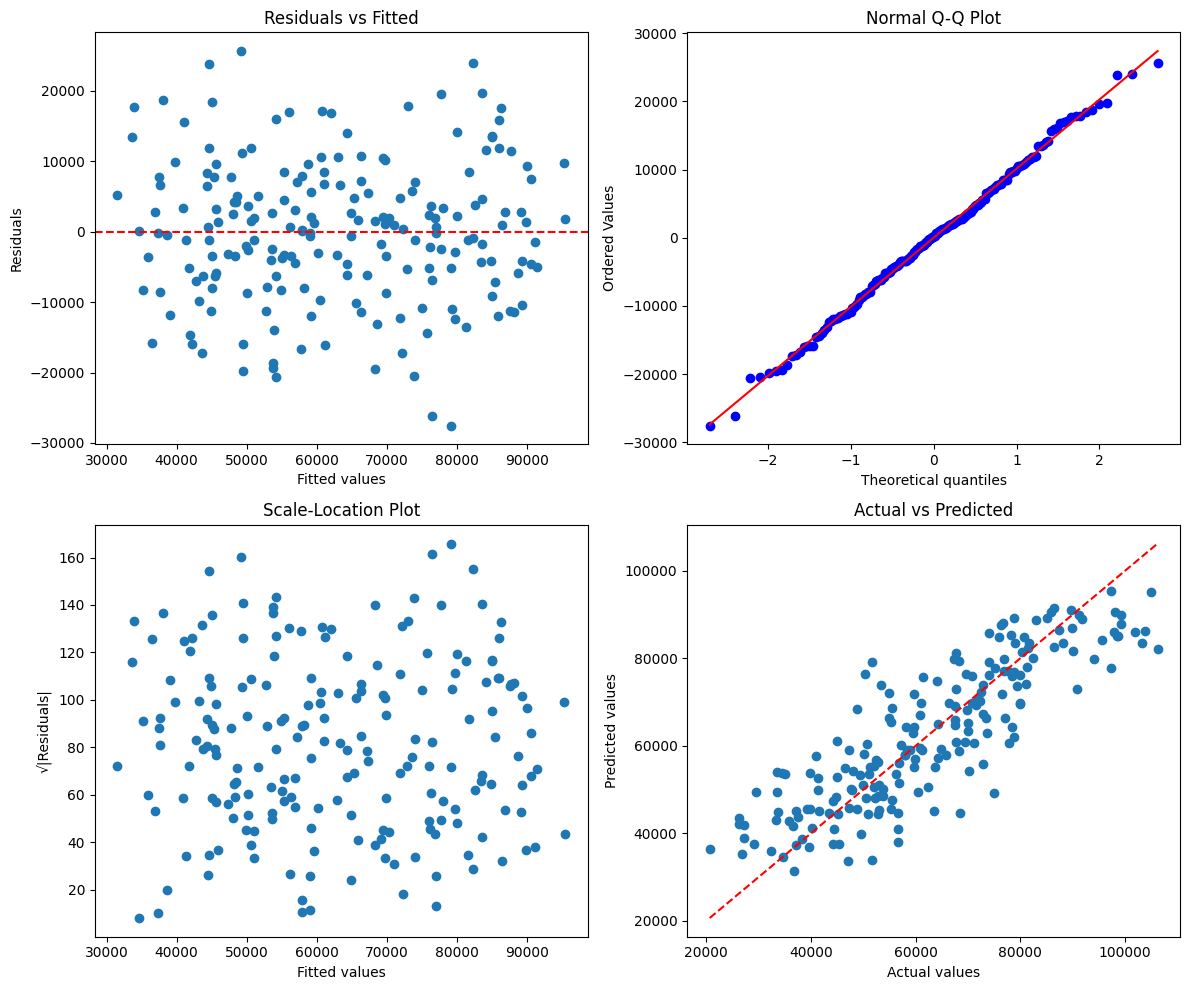

In [2]:
# Example usage with more realistic data
np.random.seed(42)

# Generate sample data
n = 200
# Age (between 25 and 65)
age = np.random.uniform(25, 65, n)
# Experience (correlated with age but with some noise)
experience = (age - 25) * 0.8 + np.random.normal(0, 2, n)
experience = np.maximum(0, experience)
# Education years (between 12 and 20)
education = np.random.normal(16, 2, n)
education = np.clip(education, 12, 20)

# Generate salary with realistic relationships and some noise
salary = (
    30000 +  # base salary
    1000 * experience +  # experience premium
    2000 * (education - 12) +  # education premium
    500 * (age - 25) +  # age premium
    np.random.normal(0, 10000, n)  # random noise
)

# Create dataset
data = pd.DataFrame({
    'Salary': salary,
    'Age': age,
    'Experience': experience,
    'Education': education
})

# Fit model
results = linear_model(data)

# Print results
print(results['summary'])
plt.show()